In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import pandas as pd
import matplotlib.pyplot as plt

from oodeel.methods import MLS, ODIN
from oodeel.eval.metrics import bench_metrics
from oodeel.datasets import OODDataset
from oodeel.models.training_funs import train_convnet_classifier

from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
os.makedirs(model_path, exist_ok=True)

## Two datasets experiment

In [2]:
oods_in = OODDataset('mnist', split="test")
oods_out = OODDataset('fashion_mnist', split="test")
oods_fit = OODDataset('mnist', split="train")

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


batch_size = 128
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_fit = oods_fit.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

In [3]:
model_path_mnist = os.path.join(model_path, "mnist_model")

try:
    model = tf.keras.models.load_model(model_path_mnist)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in#.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier(ds_fit, **train_config) #ds_fit is actually the train set of MNIST

### MLS

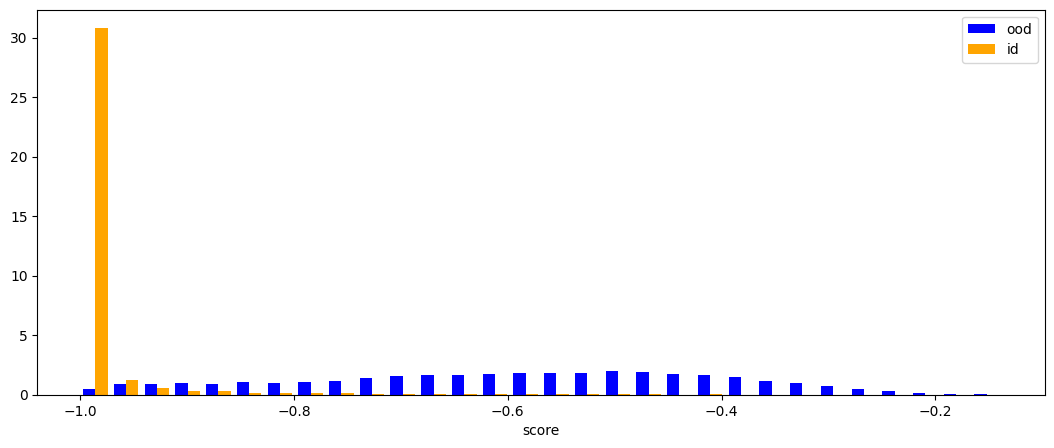

auroc             0.979693
fpr95tpr          0.072400
accuracy_score    0.941350
roc_auc_score     0.979694
dtype: float64


In [4]:
oodmodel = MLS()
oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -0.95 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

metrics = pd.Series(metrics)
print(metrics)


### ODIN

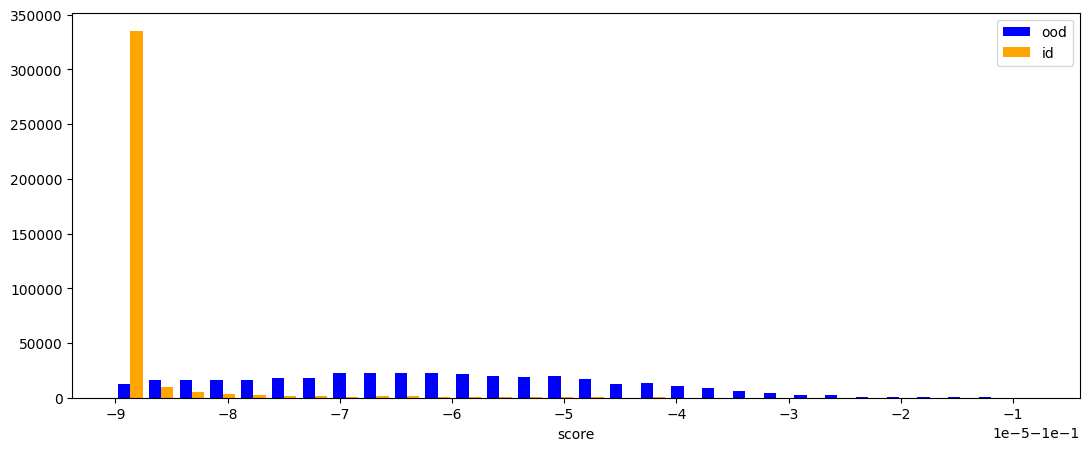

auroc             0.981468
fpr95tpr          0.068200
accuracy_score    0.935700
roc_auc_score     0.981468
dtype: float64


In [5]:
oodmodel = ODIN()
oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -8.5*1e-5 -1e-1 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

metrics = pd.Series(metrics)
print(metrics)

## Single dataset experiment

(Leave-$k$-classes-out training).
First, we need to define a training function

In [6]:
oods_fit = OODDataset('mnist', split="train")
oods_test = OODDataset('mnist', split="test")

batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
oods_fit, _ = oods_fit.assign_ood_labels_by_class(in_labels=inc_labels)
oods_in, oods_out = oods_test.assign_ood_labels_by_class(in_labels=inc_labels)


def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

ds_fit = oods_fit.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)


In [7]:
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4/")

try:
    model = tf.keras.models.load_model(model_path_mnist_04)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "is_prepared": True,
        "batch_size": 128,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier(ds_fit, **train_config) #ds_fit is actually the train set of MNIST

## MLS

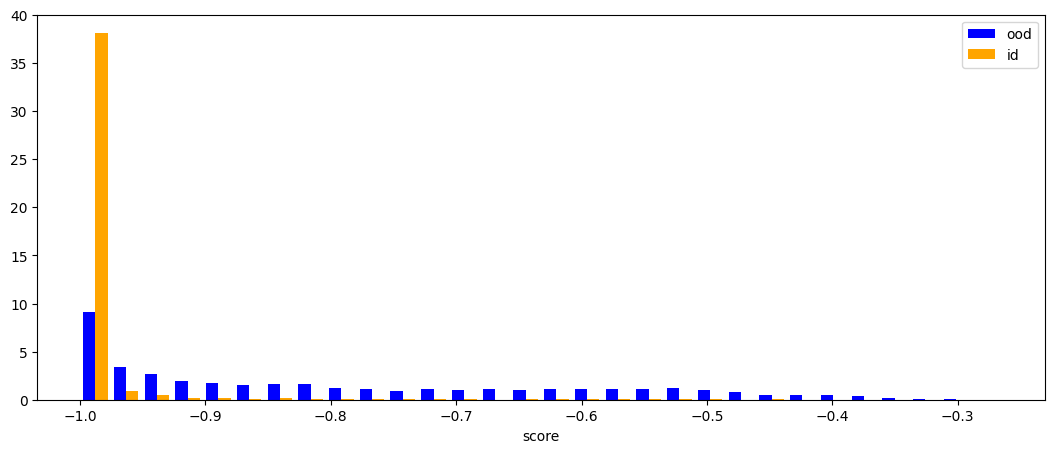

auroc             0.929005
fpr95tpr          0.414478
accuracy_score    0.828400
roc_auc_score     0.929005
dtype: float64


In [8]:
oodmodel = MLS()
oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -0.95 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

metrics = pd.Series(metrics)
print(metrics)

### ODIN

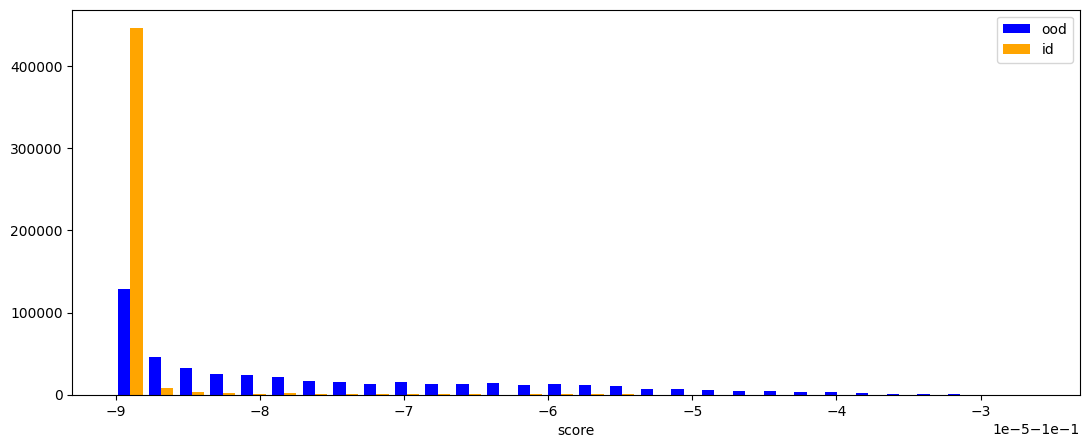

auroc             0.924118
fpr95tpr          0.407278
accuracy_score    0.789600
roc_auc_score     0.924117
dtype: float64


In [9]:
oodmodel = ODIN()
oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -8.5*1e-5 -1e-1 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

metrics = pd.Series(metrics)
print(metrics)